In [64]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import powerlaw

from SFAnalysis.analysis import fit as sffit

In [59]:
word_freqs = pd.read_csv('word_frequencies_ranks.csv')

In [3]:
word_freqs.head()

word  frequency  rank
0    και     612644     1
1     το     515117     2
2     να     484505     3
3  κυριε     308883     4
4    δεν     253830     5

In [7]:
word_freqs.tail()

word  frequency    rank
195735    συγκροτηματα-          1  195736
195736         εικοστες          1  195737
195737          πεμπτες          1  195738
195738  καθομολογουμενο          1  195739
195739            2018»          1  195740

We can start by plotting the frequencies.

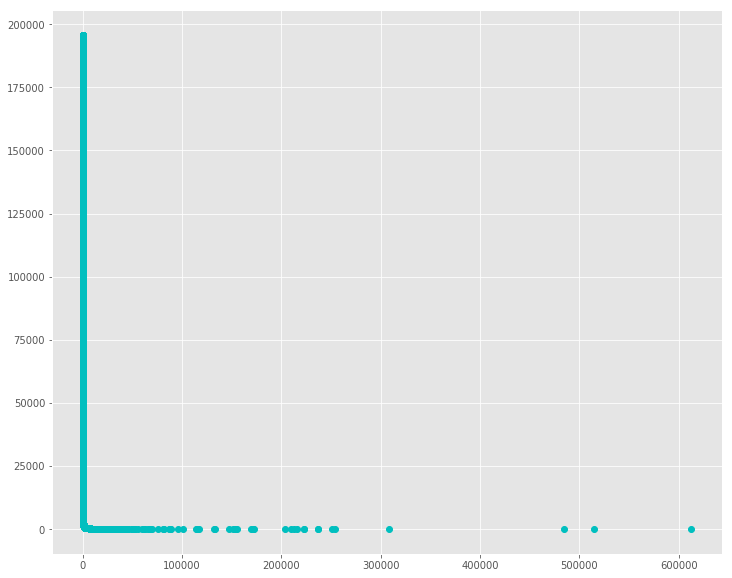

In [23]:
plt.figure(figsize=(12, 10))


plt.plot(word_freqs['frequency'], word_freqs.index, 'co')

This concentration of the points along the axes indicates that we should use logarithmic scales instead.

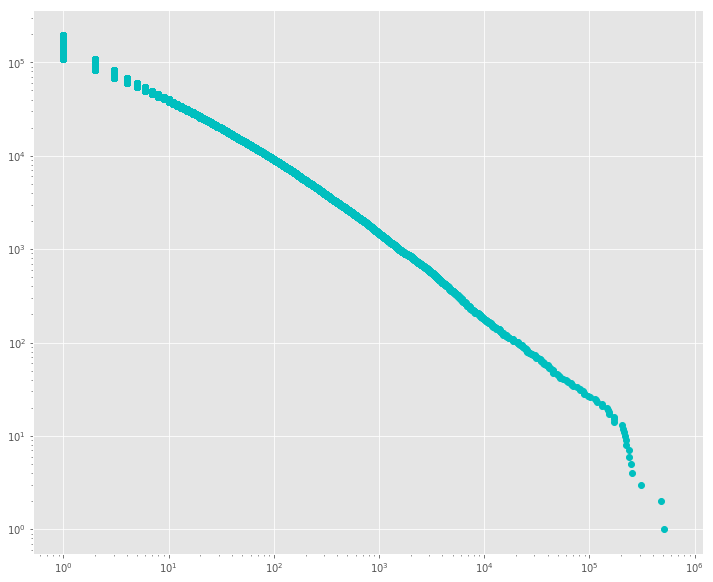

In [46]:
plt.figure(figsize=(12, 10))

plt.plot(word_freqs['frequency'], word_freqs.index, 'co')
plt.xscale('log')
plt.yscale('log')

This is clearly a heavy-tailed distribution; for most of it, it follows a straight line, as would happen if it followed a power law. The behaviour seems to change for very small and very small frequencies.

We'll start our investigation in whether we can really identify a power-law structure using the `powerlaw` package. First, we'll make a plot of the observed vs. the theoretical distribution. Note that the distribution looks different from the previous figure, as it uses logarithmic binning, and it does not plot the whole range of data, as we'll see shortly.

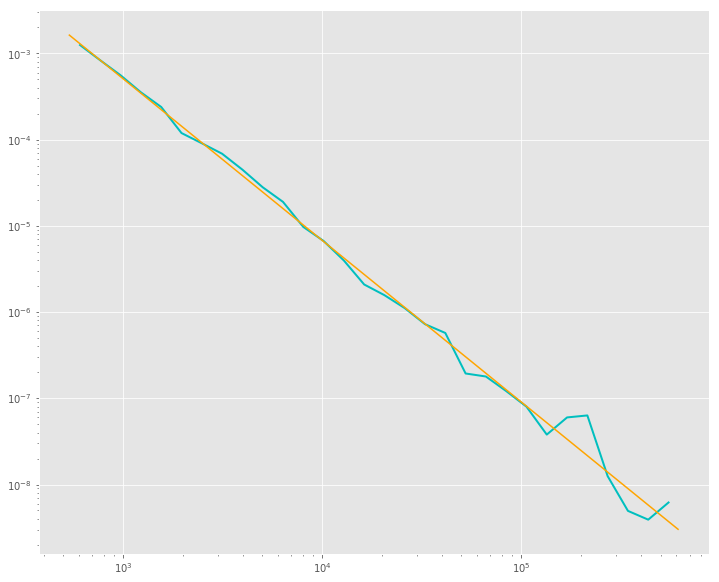

In [45]:
data = word_freqs['frequency']

plt.figure(figsize=(12, 10))

fig = fit.plot_pdf(color='c', linewidth=2)
fit.power_law.plot_pdf(data, color='Orange', ax=fig)

In [75]:
fit = powerlaw.Fit(data)
print(fit.power_law.alpha)
print(fit.power_law.xmin)
print(fit.power_law.KS(data))

Calculating best minimal value for power law fit
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


1.87467928584674
537.0
0.015403122255399415


The package identified as $x_{min} = 537$, which means that power law scaling starts at 537. That is, the portion of the dataset with words with that appear less than 537 times is not included in the fit, nor in the preceding plot.

To see whether the fitted power law really explains the data better than other distributions, we should compare the power law fit with other possible fits. The `powerlaw` package supports the following distributions:

In [76]:
fit.supported_distributions

{'power_law': powerlaw.Power_Law,
 'lognormal': powerlaw.Lognormal,
 'exponential': powerlaw.Exponential,
 'truncated_power_law': powerlaw.Truncated_Power_Law,
 'stretched_exponential': powerlaw.Stretched_Exponential,
 'lognormal_positive': powerlaw.Lognormal_Positive}

So we can try all alternatives:

In [77]:
for distribution in fit.supported_distributions.keys():
    if distribution == 'power_law':
        continue
    print('Comparing with', distribution)
    R, p = fit.distribution_compare('power_law', distribution, normalized_ratio=True)
    print(R, p)

Comparing with lognormal
-1.0169921447365329 0.30915716629534673
Comparing with exponential
11.518216182661407 1.0679907787892088e-30
Comparing with truncated_power_law


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Assuming nested distributions


-2.5727427794062825 0.014616664444942362
Comparing with stretched_exponential
1.2496450838970723 0.21142922629776084
Comparing with lognormal_positive
1.0857066539662887 0.2776087958843648


The results show that:

* We are dealing with a fat-tailed distribution, as the comparison with the exponential show that this is an extremely unlikely alternative.

* Compared to the lognormal distribution, the data favour it against the power law distribution (the sign is negative), but the result is not statistically significant.

* Compared to the truncated power law, the data favour it against the plain power law; we have $p < 0.05$, so this is unlikely to happen by chance. The truncated power law follows the power law distribution for some range, then veers off towards an exponential tail. Indeed, this can be seen in the chopped tail of the log scale plot we made.

* The power law is favoured over the stretched exponential, but the result is not statistically significant.

* Finally, it is also favoured over the lognormal positive, but the result is not statistically significant.

A good idea is to plot the distribution by distribution comparisons.

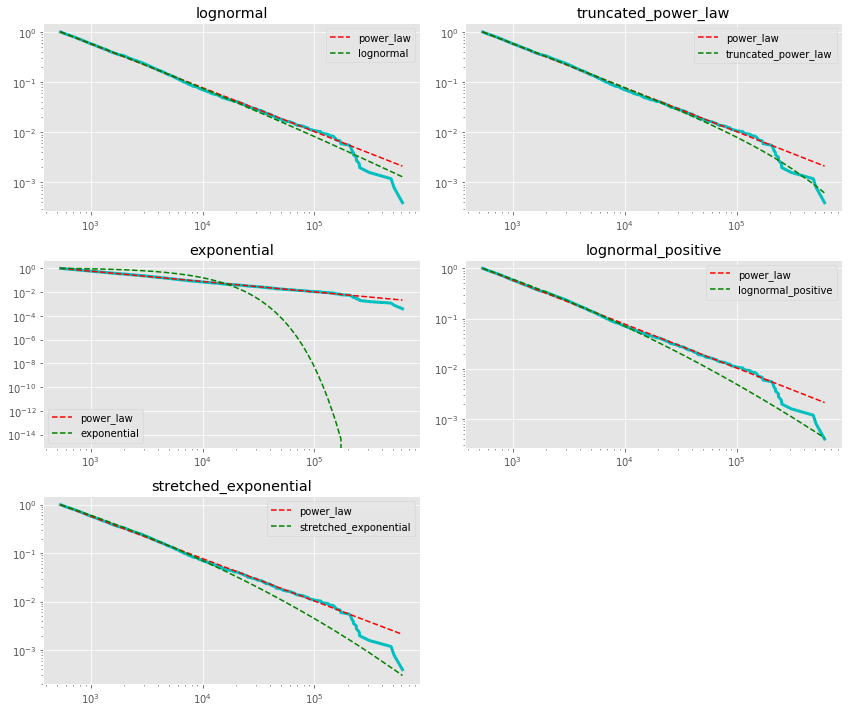

In [103]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

axes[-1][-1].axis('off')
for i, distribution in enumerate(fit.supported_distributions.keys() - set(['power_law'])):
    row = i // 2
    col = i % 2
    fit.distribution_compare('power_law', distribution_name)
    ax = axes[row][col]
    fit.plot_ccdf(linewidth=3, color='c', ax=ax)
    fit.power_law.plot_ccdf(ax=ax, color='r', linestyle='--', label='power_law')
    getattr(fit, distribution).plot_ccdf(ax=ax, color='g', linestyle='--', label=distribution)
    ax.set_title(distribution)
    ax.legend()

plt.tight_layout()

So indeed, although the exponential distribution can be dismissed, there is no clear evidence that the other ones can. 

However, we saw that the truncated power law is a better fit with the plain power law, so we can try how this fares compared to all the rest.

In [108]:
for distribution in fit.supported_distributions.keys():
    if distribution == 'truncated_power_law':
        continue
    print('Comparing with', distribution)
    R, p = fit.distribution_compare('truncated_power_law', distribution, normalized_ratio=True)
    print(R, p)

Comparing with power_law
2.5727427794062825 0.014616664444942362
Comparing with lognormal
1.5701496845031653 0.1163802920091525
Comparing with exponential
11.583410663130232 5.001572481497057e-31
Comparing with stretched_exponential
2.1155839258491107 0.034380210139133296
Comparing with lognormal_positive
1.974012828885372 0.048380284227798734


Assuming nested distributions


The truncated power law is favoured over all others, except for the lognormal: we do not have statistical evidence that the distribution is not in fact a lognormal one. We can again explore the situation graphically.

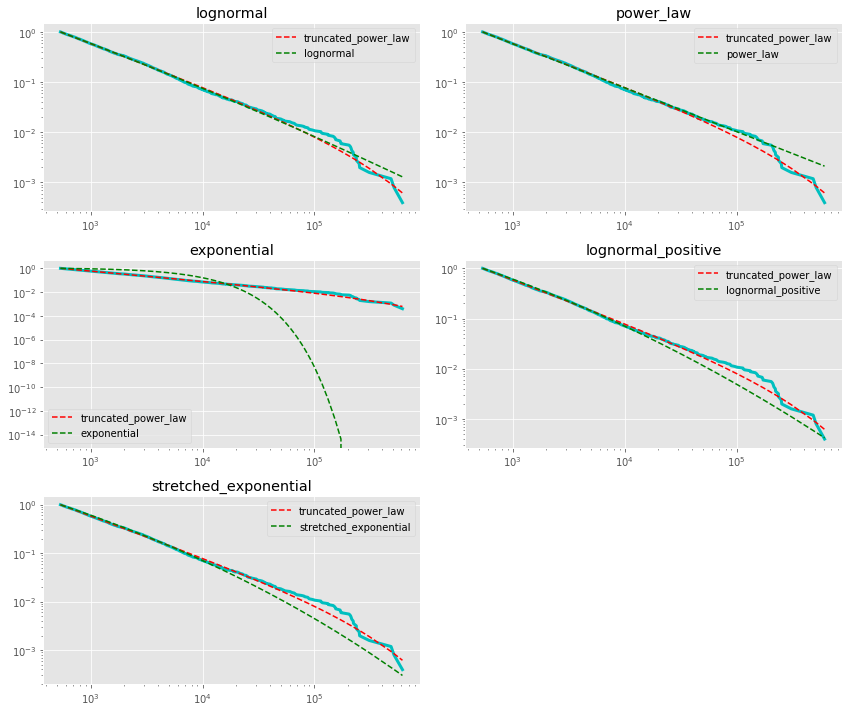

In [107]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

axes[-1][-1].axis('off')
for i, distribution in enumerate(fit.supported_distributions.keys() - set(['truncated_power_law'])):
    row = i // 2
    col = i % 2
    fit.distribution_compare('truncated_power_law', distribution_name)
    ax = axes[row][col]
    fit.plot_ccdf(linewidth=3, color='c', ax=ax)
    fit.truncated_power_law.plot_ccdf(ax=ax, color='r', linestyle='--', label='truncated_power_law')
    getattr(fit, distribution).plot_ccdf(ax=ax, color='g', linestyle='--', label=distribution)
    ax.set_title(distribution)
    ax.legend()

plt.tight_layout()

We can now move to the SFAnalysis package.

In [104]:
np_data = np.array(data)
np_data

array([612644, 515117, 484505, ...,      1,      1,      1])

In [66]:
results = sffit.pl(np_data)

/Users/panos/Documents/Work/aueb/publications/greekparliament/src/SFAnalysis/analysis/fit.py:61: RuntimeWarning: invalid value encountered in log
  Ls = -alphaV*np.sum(np.log(xtail)) - ntail*np.log(constV)


In [70]:
alpha, xmin, ntail, L, ks = results
print('alpha =', alpha)
print('xmin =', xmin)
print('ntail =', ntail)
print('L =', L)
print('ks =', ks)

alpha = 1.8100000000000007
xmin = 151
ntail = 6799
L = -50654.797708408514
ks = 0.014322330920915616


The $\alpha$  and $ks$ value are comparable to what we got before; the $x_{min}$ is apparently calculated differently. 